In [28]:
# installing all packages necessary
! pip install python-binance
! pip install cryptography

In [240]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd
import numpy as np

In [59]:
client = bnb_client(tld='US')
px = client.get_historical_klines('BTCUSDT', '1d', '2018-12-15')

In [63]:
def format_binance(data):
    columns = ['open_time', 
               'open', 
               'high', 
               'low', 
               'close', 
               'volume', 
               'close_time', 
               'quote_volume', 
               'num_trades', 
               'taker_base_volume', 
               'taker_quote_volume', 
               'ignore']

    df = pd.DataFrame(data, columns = columns)

    # convert the POXIS timestamp to actual times (number of milliseconds since Jan 1, 1970)
    df['open_time'] = df['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    df['close_time'] = df['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return df

In [64]:
formatted_px = format_binance(px)

In [65]:
formatted_px.shape

(2089, 12)

In [221]:
def get_binance_px(symbol, freq, start_time = '2019-01-01'):
    client = bnb_client(tld=')
    data = client.get_historical_klines(symbol,freq, start_time)
    data = format_binance(data)
    return data

In [258]:
univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']
freq = '1h'
px = {}
for x in univ:
    data = get_binance_px(x, freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0], px.index[-1], freq = freq))
ret = px.pct_change(fill_method=None)

In [321]:
hor = 20
port = (-1.0 * ret.rolling(hor, min_periods=1).mean()).rank(1)
port = port.subtract(port.mean(1), 0)
port = port.divide(port.abs().sum(1), 0)
port

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
2019-09-23 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-23 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-23 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-23 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-23 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-13 01:00:00,-0.166667,0.277778,0.055556,-0.277778,-0.055556,0.166667,NaN
2025-06-13 02:00:00,-0.166667,0.277778,0.166667,-0.277778,-0.055556,0.055556,NaN
2025-06-13 03:00:00,-0.166667,0.277778,0.166667,-0.277778,-0.055556,0.055556,NaN
2025-06-13 04:00:00,-0.166667,0.277778,0.166667,-0.277778,-0.055556,0.055556,NaN


In [309]:
to = (port.fillna(0) - port.shift().fillna(0)).abs().sum(1)
to

2019-09-23 08:00:00    0.000000
2019-09-23 09:00:00    0.000000
2019-09-23 10:00:00    0.000000
2019-09-23 11:00:00    0.000000
2019-09-23 12:00:00    0.000000
                         ...   
2025-06-13 01:00:00    0.222222
2025-06-13 02:00:00    0.222222
2025-06-13 03:00:00    0.000000
2025-06-13 04:00:00    0.000000
2025-06-13 05:00:00    0.000000
Freq: h, Length: 50158, dtype: float64

<Axes: >

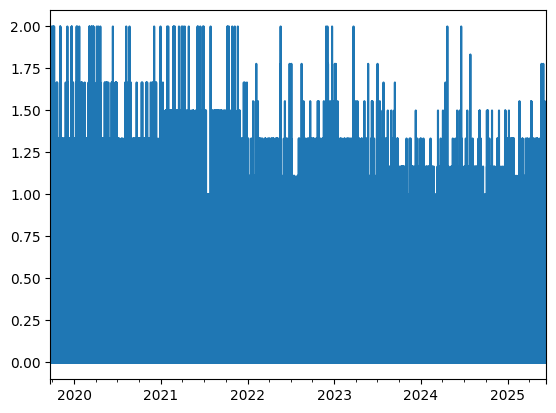

In [310]:
to.plot()

In [311]:
float(to.mean())

0.3741560003721574

In [312]:
gross_ret = (port.shift() * ret).sum(1)

In [313]:
gross_ret.mean() / gross_ret.std() * np.sqrt(12*365)

np.float64(1.5306234715539764)

In [314]:
tcost_bps = 20
net_ret = gross_ret.subtract(to * tcost_bps*1e-4, fill_value = 0)

In [315]:
net_ret.mean() / net_ret.std() * np.sqrt(12 * 365)

np.float64(-12.680343921402836)